The mathematics follows the theorems from the book:

[Capinski, M. and Zastawniak, T. (2011). Mathematics for Finance. An Introduction to Financial Engineering (Second Edition)](https://link.springer.com/gp/book/9780857290816).

## Part 1: Two Risky Assets Portfolio

In [495]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import scipy.stats as stats
import pandas as pd
import pandas_datareader as pdr
import random
from adjustText import adjust_text
from tqdm.notebook import tqdm
tqdm.pandas()

### 1.1: Theorems for the feasible set

For two risky assets, the portfolio return is:

\begin{equation}
    \mu_{v} = w_1 \mu_1 + w_2 \mu_2,
\end{equation}

and the variance is:

\begin{equation}
    \sigma^2_V = w^2_1 \sigma^2_1 + w^2_2 \sigma^2_2 + 2w_1w_2c_{12}.
\end{equation}

Here, $w_1, w_2 \in \mathbb{R}$, and $1 = w_1 + w_2$.

We use $s$ to represent the $w_1$, then the $w_2 = 1 - s$. The above equation would be:

\begin{equation}
    \mu_{v} = s \mu_1 + (1-s) \mu_2,
\end{equation}

\begin{equation}
    \sigma^2_V = s^2 \sigma^2_1 + (1-s)^2 \sigma^2_2 + 2s(1-s)c_{12}.
\end{equation}

Here $s \in \mathbb{R}$.

If $\rho < 1$, or $\sigma_1 \neq \sigma_2$, the weight of asset 1, $s_0$, with mimimum varaince $\sigma_V^2$, will be:

\begin{equation}
    s_0 = \frac{\sigma_2^2 - c_{12}}{\sigma_1^2+\sigma_2^2-2c_{12}},
\end{equation}

And the expected return $\mu_V$ and variance $\sigma_V^2$ will be:

\begin{equation}
    \mu_0=\frac{\mu_1\sigma_2^2+\mu_2\sigma_1^2-(\mu_1+\mu_2)c_{12}}{\sigma_1^2+\sigma_2^2-2c_{12}},
\end{equation}

\begin{equation}
    \sigma_0^2=\frac{\sigma_1^2\sigma_2^2-c_{12}^2}{\sigma_1^2+\sigma_2^2-2c_{12}}.
\end{equation}

If $-1<\rho_{12}<1$ and $\mu_1\neq mu_2$, then for each feasible set in the portfolio $V$, $x=\sigma_V$ and $y=\mu_V$ satisfy the following equation:

\begin{equation}
    x^2-A^2(y-\mu_0)^2=\sigma_0^2,
\end{equation}

where

\begin{equation}
    A^2 = \frac{\sigma_1^2+\sigma_2^2-2c_{12}}{(\mu_1-\mu_2)^2}>0,
\end{equation}

whose asymptotes are:

\begin{equation}
    y=\mu_0 \pm \frac{1}{A}x.
\end{equation}


In [511]:
# If require aggregated plot of all situations, set separatePlot=False and corr12 as a list of situations.

def twoAssetPlot(mu1, mu2, var1, var2, corr12, separatePlot=True):
    
    def strategy_idfier(weight):
        stratLS = ["long", "short", "ignore"]
        if weight>0:
            strategy = stratLS[0]
        elif weight<0:
            strategy = stratLS[1]
        else:
            strategy = stratLS[2]
        return strategy
    
    if separatePlot:
    
        cov12 = corr12*np.sqrt(var1)*np.sqrt(var2)
        s0 = (var2-cov12)/(var1+var2-2*cov12)
        mu0 = (mu1*var2+mu2*var1-(mu1+mu2)*cov12)/(var1+var2-2*cov12)
        var0 = (var1*var2-cov12**2)/(var1+var2-2*cov12)
        # var0 = (s0**2)*var1+((1-s0)**2)*var2+2*s0*(1-s0)*cov12
        
        sd1sd2 = np.sqrt(var1)/np.sqrt(var2)
        if corr12 == 1:
            print("[Situation 1]: correlation equals 1")
        elif corr12 > np.sqrt(var1)/np.sqrt(var2) and corr12 < 1:
            print("[Situation 2]: correlation between STD1/STD2 (%s) and 1" %round(sd1sd2,4))
        elif corr12 == np.sqrt(var1)/np.sqrt(var2):
            print("[Situation 3]: correlation equals STD1/STD2 (%s)" %round(sd1sd2,4))
        elif corr12 < np.sqrt(var1)/np.sqrt(var2) and corr12 > -1:
            print("[Situation 4]: correlation between -1 and STD1/STD2 (%s)" %round(sd1sd2,4))
        elif corr12 == -1:
            print("[Situation 5]: correlation equals -1")
        else:
            print("[Error: correlation out of range]")

        print("MVP strategy (weight): %s asset 1 (%s%%), and %s asset 2 (%s%%)"
              %(strategy_idfier(round(s0,4)),round(100*s0,2),strategy_idfier(round(1-s0,4)),round(100*(1-s0),2)))
        print("Return of MVP: %s" % round(mu0,4))
        print("Minimum variance: %s" % round(var0,4))
        print("Covariance: %s" % round(cov12,4))

        f = plt.figure(figsize = (10,8))
        ax = f.add_subplot(1, 1, 1)
        
        x = np.linspace(0, max((np.sqrt(var1),np.sqrt(var2)))*(5/3), 400)
        y = np.linspace(min(mu1,mu2,mu0)-np.abs(2/3)*max(mu1,mu2,mu0), max(mu1,mu2,mu0)+np.abs((2/3)*max(mu1,mu2,mu0)), 400)
        x, y = np.meshgrid(x, y)
        
        x2 = np.linspace(0, max(np.sqrt(var1),np.sqrt(var2),np.sqrt(np.abs(var0)))*(5/3))
        y2 = mu0+np.sqrt((((mu1-mu2)**2)/(var1+var2-2*cov12)))*x2
        y3 = mu0-np.sqrt((((mu1-mu2)**2)/(var1+var2-2*cov12)))*x2  
        plt.plot(x2, y2,color='grey',lw=1,ls='--')
        plt.plot(x2, y3,color='grey',lw=1,ls='--')
        
        formula = ((y-mu0)**2-(x**2-var0)*(((mu1-mu2)**2)/(var1+var2-2*cov12)))
        maskedLong = (y<min(mu1,mu2))|(max(mu1,mu2)<y)
        maskedShort = (y>=min(mu1,mu2))&(y<=max(mu1,mu2))
        plt.contour(np.ma.masked_where(maskedLong,x),np.ma.masked_where(maskedLong,y),np.ma.masked_where(maskedLong,formula), [0], colors='deepskyblue', linestyles='-')
        plt.contour(np.ma.masked_where(maskedShort,x),np.ma.masked_where(maskedShort,y),np.ma.masked_where(maskedShort,formula), [0], colors='deepskyblue', linestyles='--')
        plt.hlines(mu0,0,np.sqrt(np.abs(var0)),color='grey',lw=1,ls='--')
        plt.vlines(np.sqrt(np.abs(var0)),0,mu0,color='grey',lw=1,ls='--')
        
        twoAssets = [[np.sqrt(var1), np.sqrt(var2)], [mu1, mu2]]
        plt.scatter(*twoAssets, marker='v', color='red')
        text1 = plt.text(np.sqrt(var1), mu1, "(σ1, μ1)")
        text2 = plt.text(np.sqrt(var2), mu2, "(σ2, μ2)")

        minVar = [[np.sqrt(np.abs(var0))], [mu0]]
        plt.scatter(*minVar, marker='x', color='purple')
        text3 = plt.text(np.sqrt(np.abs(var0)), mu0, "Min(σ)")
        adjust_text([text1, text2, text3])
        
        plt.xlabel("Standard Deviation (σ)")
        plt.ylabel("Expected Return (μ)")
        ax.spines['left'].set_position('zero')
        ax.spines['bottom'].set_position('zero')
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        plt.show()
        
    else:
        sd1sd2 = np.sqrt(var1)/np.sqrt(var2)
        print("STD1/STD2 = %s" %round(sd1sd2,4))
        f = plt.figure(figsize = (10,10))
        ax = f.add_subplot(1, 1, 1)
        colorIdx = 0
        colorlabel = {}
        for situation in corr12:
            cov12 = situation*np.sqrt(var1)*np.sqrt(var2)
            s0 = (var2-cov12)/(var1+var2-2*cov12)
            mu0 = (mu1*var2+mu2*var1-(mu1+mu2)*cov12)/(var1+var2-2*cov12)
            var0 = (var1*var2-cov12**2)/(var1+var2-2*cov12)
            
            print("[Situation %s] MVP: (%s, %s), covariance = %s;" %(colorIdx+1, round(np.sqrt(np.abs(var0)),4), round(mu0,4), round(cov12,4)))
            print("MVP strategy (weight): %s asset 1 (%s%%), and %s asset 2 (%s%%)"
                  %(strategy_idfier(round(s0,4)),round(100*s0,2),strategy_idfier(round(1-s0,4)),round(100*(1-s0),2)))
            
            x = np.linspace(0, max((np.sqrt(var1),np.sqrt(var2)))*(5/3), 400)
            y = np.linspace(min(mu1,mu2,mu0)-np.abs(2/3)*max(mu1,mu2,mu0), max(mu1,mu2,mu0)+np.abs((2/3)*max(mu1,mu2,mu0)), 400)
            x, y = np.meshgrid(x, y)

            twoAssets = [[np.sqrt(var1), np.sqrt(var2)], [mu1, mu2]]
            plt.scatter(*twoAssets, marker='v', color='red')
            
            formula = ((y-mu0)**2-(x**2-var0)*(((mu1-mu2)**2)/(var1+var2-2*cov12)))
            maskedLong = (y<min(mu1,mu2))|(max(mu1,mu2)<y)
            maskedShort = (y>=min(mu1,mu2))&(y<=max(mu1,mu2))
            color = list(mcolors.TABLEAU_COLORS.values())
            plt.contour(np.ma.masked_where(maskedLong,x),np.ma.masked_where(maskedLong,y),np.ma.masked_where(maskedLong,formula), [0], colors=color[colorIdx], linestyles='-')
            plt.contour(np.ma.masked_where(maskedShort,x),np.ma.masked_where(maskedShort,y),np.ma.masked_where(maskedShort,formula), [0], colors=color[colorIdx], linestyles='--')
            colorlabel["Situation %s" %(colorIdx+1)] = color[colorIdx]
            colorIdx += 1
            plt.hlines(mu0,0,np.sqrt(np.abs(var0)),color='grey',lw=1,ls='--')
            plt.vlines(np.sqrt(np.abs(var0)),0,mu0,color='grey',lw=1,ls='--')
            
            minVar = [[np.sqrt(np.abs(var0))], [mu0]]
            plt.scatter(*minVar, marker='x', color='purple')
            
        text1 = plt.text(np.sqrt(var1), mu1, "(σ1, μ1)")
        text2 = plt.text(np.sqrt(var2), mu2, "(σ2, μ2)")
        adjust_text([text1,text2])
        
        fake_handles = [mpatches.Patch(color=item) for item in colorlabel.values()]
        plt.legend(fake_handles, colorlabel.keys(), loc='upper left', prop={'size': 10})
        plt.xlabel("Standard Deviation (σ)")
        plt.ylabel("Expected Return (μ)")
        ax.spines['left'].set_position('zero')
        ax.spines['bottom'].set_position('zero')
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        plt.show()
        


### 1.2 Simulation with predefined returns and variances

First, we can manually simulate the expected return and the variance of two assets, and the correlation between two assets, and see what the plot will be.

Variables are:

- `mu1` and `mu2`: $\mu_{1}$ and $\mu_{2}$, the expected return of asset 1 and 2.
- `var1` and `var2`: $\sigma_{1}$ and $\sigma_{2}$, the variance of asset 1 and 2 ($\sigma_1 \neq \sigma_2$). 
- `corr12`: $\rho_{12}$, the correlation between asset 1 and 2. $\rho_{12}=\frac{c_{12}}{\sigma_1\sigma_2}, \rho_{12} \in [-1,1]$

[Situation 4]: correlation between -1 and STD1/STD2 (0.7071)
MVP strategy (weight): long asset 1 (81.13%), and long asset 2 (18.87%)
Return of MVP: 0.0219
Minimum variance: 0.0141
Covariance: 0.0105


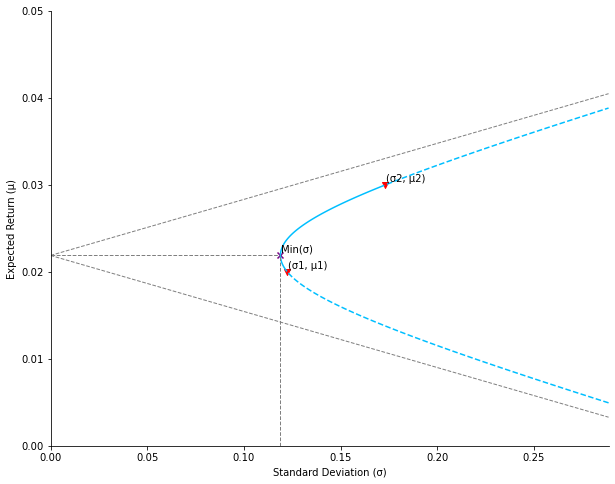

In [512]:

mu1 = 0.02
mu2 = 0.03
var1 = 0.015
var2 = 0.03

# corr12 = np.sqrt(var1)/np.sqrt(var2)
corr12 = random.uniform(-1,1)

twoAssetPlot(mu1, mu2, var1, var2, corr12)

Assume $\sigma_1 \leq \sigma_2$, the plausible situations are:

1. If $\rho = 1$, there is a feasible set with short selling such that $\sigma_V=0$.

2. If $\frac{\sigma_1}{\sigma_2}<\rho<1$, the feasible set includes a short position, and $\sigma_V<\sigma_1$. But for every set without short selling, $\sigma_V\geq \sigma_1$.

3. If $\rho = \frac{\sigma_1}{\sigma_2}$, for every attainable set, $\sigma_V \geq \sigma_1$.

4. If $-1<\rho<\frac{\sigma_1}{\sigma_2}$, the feasible set without short selling has $\sigma_V<\sigma_1$.

5. If $\rho = -1$, a feasible set without short selling has $\sigma_V=0$.

[Situation 1]: correlation equals 1
MVP strategy (weight): long asset 1 (341.42%), and short asset 2 (-241.42%)
Return of MVP: -0.0524
Minimum variance: 0.0
Covariance: 0.0212


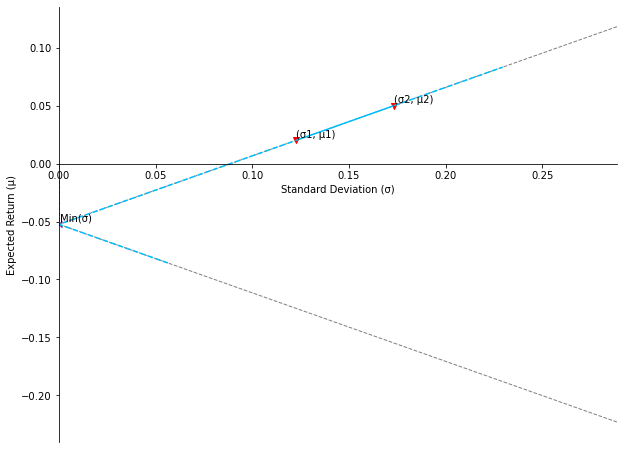

[Situation 2]: correlation between STD1/STD2 (0.7071) and 1
MVP strategy (weight): long asset 1 (117.5%), and short asset 2 (-17.5%)
Return of MVP: 0.0147
Minimum variance: 0.0147
Covariance: 0.0169


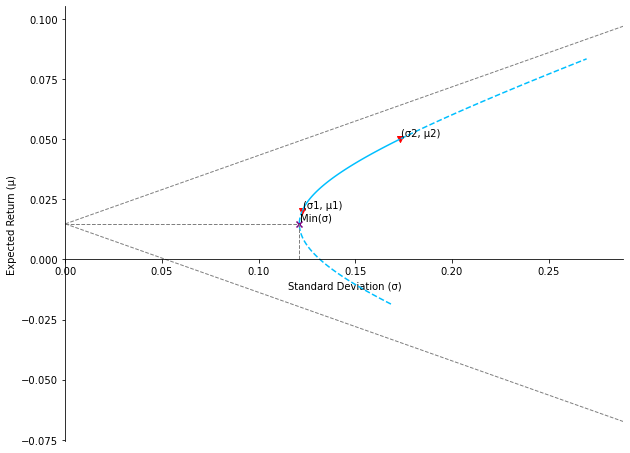

[Situation 3]: correlation equals STD1/STD2 (0.7071)
MVP strategy (weight): long asset 1 (100.0%), and ignore asset 2 (0.0%)
Return of MVP: 0.02
Minimum variance: 0.015
Covariance: 0.015


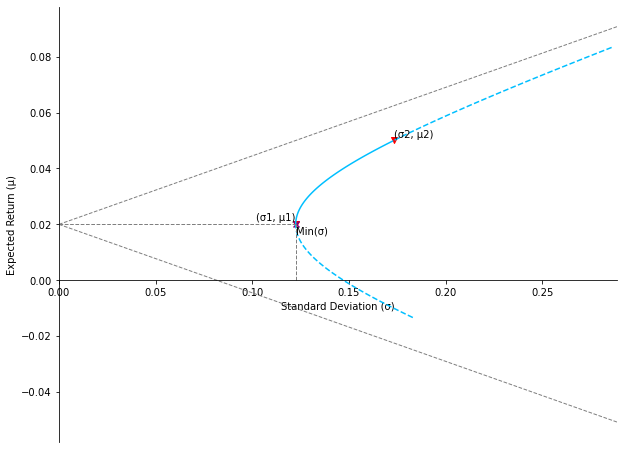

[Situation 4]: correlation between -1 and STD1/STD2 (0.7071)
MVP strategy (weight): long asset 1 (64.54%), and long asset 2 (35.46%)
Return of MVP: 0.0306
Minimum variance: 0.0085
Covariance: -0.0033


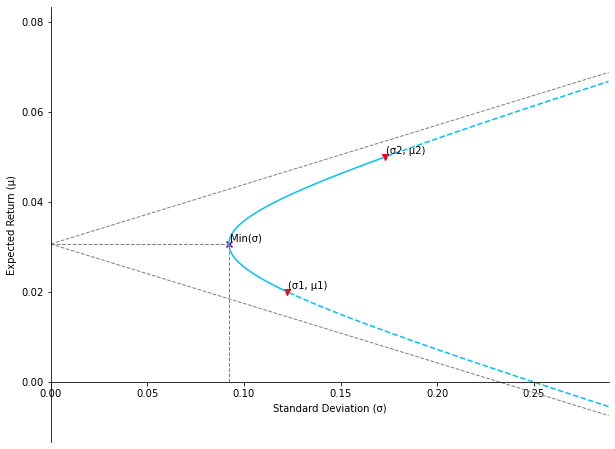

[Situation 5]: correlation equals -1
MVP strategy (weight): long asset 1 (58.58%), and long asset 2 (41.42%)
Return of MVP: 0.0324
Minimum variance: 0.0
Covariance: -0.0212


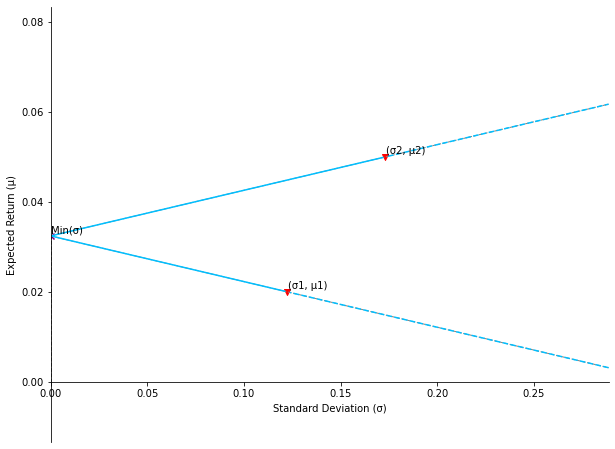

In [513]:

mu1 = 0.02
mu2 = 0.05
var1 = 0.015
var2 = 0.03

corr12 = [1, random.uniform(np.sqrt(var1)/np.sqrt(var2), 1), np.sqrt(var1)/np.sqrt(var2), 
          random.uniform(-1, np.sqrt(var1)/np.sqrt(var2)), -1]

if var1>0 and var2>0 and var1 != var2: 
    for situation in map(lambda x: twoAssetPlot(mu1, mu2, var1, var2, x), corr12):
        situation
else:
    print("Error: reset variance")


STD1/STD2 = 0.7071
[Situation 1] MVP: (0.0, -0.0524), covariance = 0.0212;
MVP strategy (weight): long asset 1 (341.42%), and short asset 2 (-241.42%)
[Situation 2] MVP: (0.1211, 0.0147), covariance = 0.0169;
MVP strategy (weight): long asset 1 (117.5%), and short asset 2 (-17.5%)
[Situation 3] MVP: (0.1225, 0.02), covariance = 0.015;
MVP strategy (weight): long asset 1 (100.0%), and ignore asset 2 (0.0%)
[Situation 4] MVP: (0.0923, 0.0306), covariance = -0.0033;
MVP strategy (weight): long asset 1 (64.54%), and long asset 2 (35.46%)
[Situation 5] MVP: (0.0, 0.0324), covariance = -0.0212;
MVP strategy (weight): long asset 1 (58.58%), and long asset 2 (41.42%)


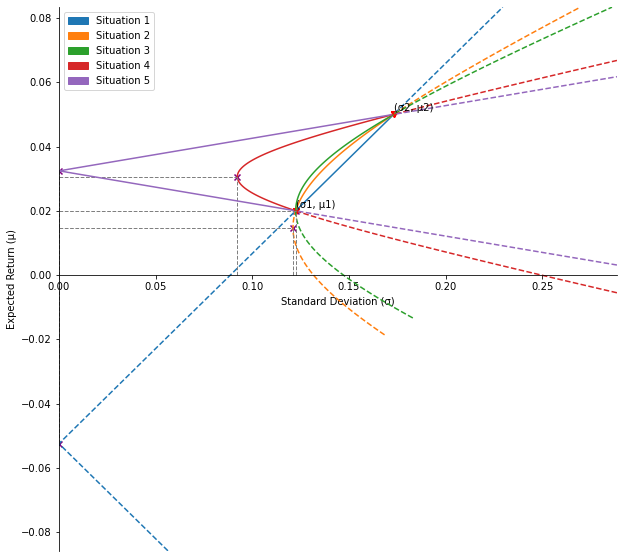

In [514]:

# corr12 = [1, random.uniform(np.sqrt(var1)/np.sqrt(var2), 1), np.sqrt(var1)/np.sqrt(var2), 
#           random.uniform(-1, np.sqrt(var1)/np.sqrt(var2)), -1]

twoAssetPlot(mu1, mu2, var1, var2, corr12, separatePlot=False)


### 1.3: Example with financial data

For convenience, below provides an example using the monthly value-weighted returns of the portfolio sorted on variance decile, from the [Fama/French Data Library](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html). 

See [pandas-datareader](https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#remote-data-ff) for a wider range of data choices using `DataReader`.


In [438]:

df = pdr.DataReader('Portfolios_Formed_on_VAR', 'famafrench')


In [536]:
df_vwr = df[0].progress_apply(lambda x: x*0.01)

df_vwr.head(10)

  0%|          | 0/15 [00:00<?, ?it/s]

,Lo 20,Qnt 2,Qnt 3,Qnt 4,Hi 20,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10
Date,,,,,,,,,,,,,,,
2017-04,0.0169,0.0033,0.0050,0.0087,-0.0028,0.0192,0.0135,0.0030,0.0040,0.0074,0.0016,0.0081,0.0097,0.0069,-0.0150
2017-05,0.0241,-0.0045,-0.0107,-0.0037,-0.0142,0.0253,0.0214,-0.0021,-0.0069,-0.0198,-0.0002,-0.0224,0.0183,-0.0056,-0.0269
2017-06,-0.0047,0.0270,0.0252,0.0226,0.0346,0.0003,-0.0109,0.0302,0.0183,0.0259,0.0239,0.0117,0.0344,0.0221,0.0579
2017-07,0.0203,0.0181,0.0241,0.0095,0.0273,0.0141,0.0276,0.0162,0.0225,0.0235,0.0249,0.0116,0.0074,0.0331,0.0200
2017-08,0.0079,0.0061,-0.0074,-0.0185,-0.0084,0.0104,0.0049,0.0125,-0.0084,-0.0093,-0.0047,-0.0277,-0.0083,-0.0241,0.0115
2017-09,0.0217,0.0188,0.0362,0.0526,0.0444,0.0092,0.0374,0.0261,0.0085,0.0328,0.0426,0.0517,0.0536,0.0311,0.0731
2017-10,0.0304,0.0257,0.0062,0.0214,-0.0219,0.0310,0.0293,0.0322,0.0164,0.0017,0.0161,0.0166,0.0270,-0.0208,-0.0237
2017-11,0.0340,0.0287,0.0358,0.0313,0.0322,0.0345,0.0335,0.0320,0.0247,0.0584,0.0164,0.0247,0.0356,0.0238,0.0485
2017-12,0.0120,0.0095,0.0197,0.0002,0.0235,0.0053,0.0193,0.0103,0.0084,0.0205,0.0190,-0.0004,0.0016,0.0191,0.0299


In [525]:
def twoFinancePlot(df, firstCol, secondCol):
    mu1 = df.mean().loc[firstCol] 
    mu2 = df.mean().loc[secondCol]
    var1 = df.std().loc[firstCol] 
    var2 = df.std().loc[secondCol]
    corr12 = df[firstCol].corr(df[secondCol], method='pearson', min_periods=None)
    return twoAssetPlot(mu1, mu2, var1, var2, corr12)

[Situation 2]: correlation between STD1/STD2 (0.8082) and 1
MVP strategy (weight): long asset 1 (123.68%), and short asset 2 (-23.68%)
Return of MVP: 0.015
Minimum variance: 0.0459
Covariance: 0.0509


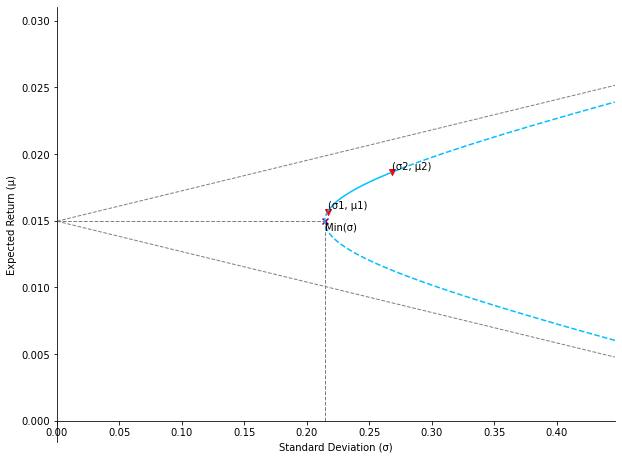

In [544]:
# choose any two of the portfolios on variance decile

twoFinancePlot(df_vwr, "Dec 2", "Dec 7")